### Alright, Time for the Grand Finale.

We've gotten the models to learn the Simple Color Game in a 2x2 and a 3x3 grid, so now it's time to build up to the full 2-player Embodied Communication Game. The first step I'm going to take is to add a 5th action, "Stop" to the models, which they will have to take on the target square to recieve a reward.

I'll also be training the models here using a curriculum approach, where the reward function changes over time. I'll first allow them to recieve a reward whenever they touch the target square, then I'll give them an increased reward when they stop on the target square. Finally, I'll remove all other rewards.

In [1]:
#Imports
# GYMNASIUM IMPORTS
from typing import Optional
import numpy as np
import gymnasium as gym

# SB3 ALGORITHM IMPORTS
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

from functions import plot_results, plot_multi

In [11]:
#This will be the v1 of the game, with a stop function included.
class SimpleColorGame(gym.Env):
    # Initializes the Env, including observation space and action space. This one initializes the Observation space as a grid
    # of boxes with colors assigned to them, and the action space as the movement of the agent along the grid.
    def __init__(self, size=2, step_limit=200):
        # The size of one side of the square grid. It will be NxN squares in area, where N is self._size
        self._size = size
        self._num_colors = size**2

        # This is a time limit on the number of steps the agent is allowed to take in the game. This is necessary to
        # prevent the game from running forever if the agent's policy prevents it from moving or reaching the target.
        self._step_limit = step_limit
        # Integer to keep track of the number of steps taken in a particular iteration of the game
        self._step_count = 0

        #Boolean flag for STOP action. When the agent stops, this becomes true.
        self._stopped = False;

        # The agent location is stored inside of a local variable.
        self._agent_location = np.array([-1, -1], dtype=np.int32)

        # The colors of the boxes are also stored in a local variable. These colors are randomized on start-up. For this
        # version of the game, I will substitute integer values for colors.
        self._square_colors = np.arange(self._num_colors).reshape(size, size)

        # The target color will be a random number between 1 and 4. This number will be initialized during the reset() method.
        self._target_color = np.random.randint(0, self._num_colors)

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
                "agent location": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "square colors": gym.spaces.Box(
                    0, self._num_colors - 1, shape=(size, size), dtype=int
                ),
                "target color": gym.spaces.Discrete(self._num_colors),
            }
        )

        # We have 5 actions, corresponding to "right", "up", "left", "down", and "stop"
        self.action_space = gym.spaces.Discrete(5)

        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([0,0]), #stop
        }

    # Helper method used to get the observation from the state, useful in reset and step methods. This version returns
    # the properties of agent location, square colors, and the target color.
    def _get_obs(self):
        return {
            "agent location": self._agent_location,
            "square colors": self._square_colors,
            "target color": self._target_color,
        }

    # Helper method used to get auxiliary information from the state. Currently returns nothing.
    def _get_info(self):
        info = {"info": None}
        return info

    # Helper method for calculating the reward from the state. This will be useful as I can override it in child classes.
    def _get_reward(self):
        reward = 0
        if (self._square_colors[tuple(self._agent_location)] == self._target_color):
            reward = 2 if (self._stopped == True) else 1
        return reward

    # Reset the environment to an initial configuration. The initial state may involve some randomness, so the seed argument
    # is used to guarantee an identical initial state whenever reset() is called with that seed. Options is a dict containing
    # any additional parameters we might want to specify during the reset.
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):

        # Firstly, we will call this method to seed self.np_random with the seed argument if given.
        super().reset(seed=seed)

        # Reset the step count to 0 for the new iteration of the game
        self._step_count = 0

        # Now randomly generate a starting location for the agent using self.np_random. We generate an array of size two
        # representing the agent's starting coordinates.
        self._agent_location = self.np_random.integers(0, self._size, size=2)

        # Generate a random permutation of the square colors, and reshape them into a sizeXsize grid.
        self._square_colors = self.np_random.permutation(self._num_colors).reshape(
            self._size, self._size
        )

        # Now we generate the target color, which is a random integer from 0 to self._num_colors inclusive.
        self._target_color = self.np_random.integers(0, self._num_colors)

        # Now we can return the observation and auxiliary info
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    # Takes an action as input and updates the state of the Env according to that Action. Step then returns an observation
    # containing the new Env state, as well as some other additional variables and info.
    def step(self, action):
        # First, iterate the step count by one
        self._step_count += 1

        # Next, we convert our action to a direction.
        direction = self._action_to_direction[action]

        #Finally, we check for the STOP action.
        if action == 4:
            self._stopped = True

        # Then we add the direction coordinates to the agend coordinates to get the new agent location. We must clip the
        # agent location at the Box boundary, so the agent's coordinates are within 0 and self._size-1.
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self._size - 1
        )

        # Now we terminate the game and give the agent a reward if the square it's standing on is the target color.
        terminated = (
            self._square_colors[tuple(self._agent_location)] == self._target_color
        )

        # We also truncate the game if self._step_count > self._step_limit.
        truncated = self._step_count > self._step_limit

        # Reward is 1 if we are on the target color square, otherwise 0
        reward = self._get_reward()

        # Finally, use the helper functions to generate Obs and Info.
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info


# Now let's register this environment with a namespace and try calling gym.make on it later
gym.register(id="SimpleColorGame-v1", entry_point=SimpleColorGame)

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment SimpleColorGame-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [12]:
#This will be the v1 of the game, with a stop function included.
class StopOnColorGame(gym.Env):
    # Initializes the Env, including observation space and action space. This one initializes the Observation space as a grid
    # of boxes with colors assigned to them, and the action space as the movement of the agent along the grid.
    def __init__(self, size=2, step_limit=200):
        self._size = size
        self._num_colors = size**2
        self._step_limit = step_limit
        self._step_count = 0
        self._stopped = False;

        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._square_colors = np.arange(self._num_colors).reshape(size, size)
        self._target_color = np.random.randint(0, self._num_colors)
        
        self.observation_space = gym.spaces.Dict(
            {
                "agent location": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "square colors": gym.spaces.Box(
                    0, self._num_colors - 1, shape=(size, size), dtype=int
                ),
                "target color": gym.spaces.Discrete(self._num_colors),
            }
        )
        self.action_space = gym.spaces.Discrete(5)

        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([0,0]), #stop
        }

    # Helper method used to get the observation from the state, useful in reset and step methods. This version returns
    # the properties of agent location, square colors, and the target color.
    def _get_obs(self):
        return {
            "agent location": self._agent_location,
            "square colors": self._square_colors,
            "target color": self._target_color,
        }

    # Helper method used to get auxiliary information from the state. Currently returns nothing.
    def _get_info(self):
        info = {"info": None}
        return info

    # Helper method for calculating the reward from the state. This will be useful as I can override it in child classes.
    def _get_reward(self):
        reward = 1 if (self._stopped == True and self._square_colors[tuple(self._agent_location)] == self._target_color) else 0
        return reward

    def _get_terminated(self):
        return self._stopped

    def _get_truncated(self):
        return self._step_count > self._step_limit;
    # Reset the environment to an initial configuration. The initial state may involve some randomness, so the seed argument
    # is used to guarantee an identical initial state whenever reset() is called with that seed. Options is a dict containing
    # any additional parameters we might want to specify during the reset.
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):

        # Firstly, we will call this method to seed self.np_random with the seed argument if given.
        super().reset(seed=seed)

        # Reset the step count to 0 for the new iteration of the game
        self._step_count = 0

        # Reset the _stopped flag
        self._stopped = False

        # Now randomly generate a starting location for the agent using self.np_random. We generate an array of size two
        # representing the agent's starting coordinates.
        self._agent_location = self.np_random.integers(0, self._size, size=2)

        # Generate a random permutation of the square colors, and reshape them into a sizeXsize grid.
        self._square_colors = self.np_random.permutation(self._num_colors).reshape(
            self._size, self._size
        )

        # Now we generate the target color, which is a random integer from 0 to self._num_colors inclusive.
        self._target_color = self.np_random.integers(0, self._num_colors)

        # Now we can return the observation and auxiliary info
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    # Takes an action as input and updates the state of the Env according to that Action. Step then returns an observation
    # containing the new Env state, as well as some other additional variables and info.
    def step(self, action):
        # First, iterate the step count by one
        self._step_count += 1

        # Next, we convert our action to a direction.
        direction = self._action_to_direction[action]

        #Finally, we check for the STOP action.
        if action == 4:
            self._stopped = True

        # Then we add the direction coordinates to the agend coordinates to get the new agent location. We must clip the
        # agent location at the Box boundary, so the agent's coordinates are within 0 and self._size-1.
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self._size - 1
        )
        terminated = self._get_terminated()
        truncated = self._get_truncated()
        reward = self._get_reward()
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info


# Now let's register this environment with a namespace and try calling gym.make on it later
gym.register(id="StopOnColorGame-v0", entry_point=StopOnColorGame)

In [3]:
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log"
game = "SOCG-v0-s2"
mPPO_dir = f"{log_dir}/{game}/mPPO/"
mA2C_dir = f"{log_dir}/{game}/mA2C/"

In [20]:
# env_PPO = Monitor(gym.make("StopOnColorGame-v0"),mPPO_dir)
# env_A2C = Monitor(gym.make("StopOnColorGame-v0"),mA2C_dir)

mPPO = PPO("MultiInputPolicy",env_PPO,verbose=0)
mA2C = A2C("MultiInputPolicy",env_A2C,verbose=0)

mPPO.learn(100000, callback = EvalCallback(env, best_model_save_path=mPPO_dir, eval_freq=20000), progress_bar=True)
mA2C.learn(100000, callback = EvalCallback(env, best_model_save_path=mA2C_dir, eval_freq=20000), progress_bar=True)

Output()

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: 
Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode 
lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor``
wrapper.
  warnings.warn(

Eval num_timesteps=20000, episode_reward=0.40 +/- 0.49

Episode length: 81.00 +/- 97.98

New best mean reward!

Eval num_timesteps=40000, episode_reward=0.20 +/- 0.40

Episode length: 41.20 +/- 79.90

Eval num_timesteps=60000, episode_reward=0.60 +/- 0.49

Episode length: 41.60 +/- 79.70

New best mean reward!

Eval num_timesteps=80000, episode_reward=0.80 +/- 0.40

Episode length: 1.80 +/- 0.40

New best mean reward!

Eval num_timesteps=100000, episode_reward=0.80 +/- 0.40

Episode length: 41.60 +/- 79.70

Output()

Eval num_timesteps=20000, episode_reward=0.20 +/- 0.40

Episode length: 1.00 +/- 0.00

New best mean reward!

Eval num_timesteps=40000, episode_reward=0.40 +/- 0.49

Episode length: 1.00 +/- 0.00

New best mean reward!

Eval num_timesteps=60000, episode_reward=0.20 +/- 0.40

Episode length: 1.00 +/- 0.00

Eval num_timesteps=80000, episode_reward=0.20 +/- 0.40

Episode length: 1.00 +/- 0.00

Eval num_timesteps=100000, episode_reward=0.00 +/- 0.00

Episode length: 1.00 +/- 0.00

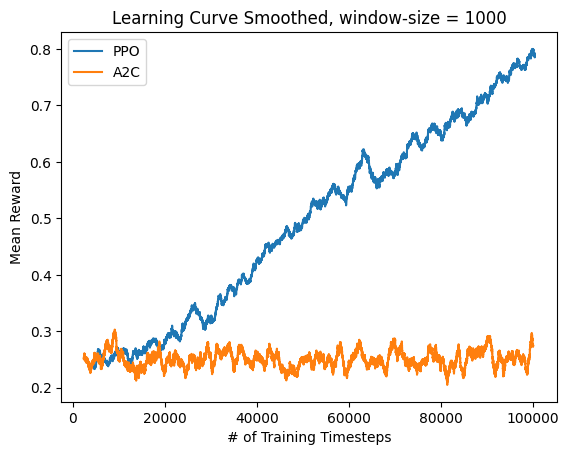

In [4]:
plot_multi([mPPO_dir,mA2C_dir],["PPO","A2C"],window=1000)

### Evidently, PPO is able to solve the 2x2 relatively quickly

even when an additional "Stopping" step is required. Now we just have to design the 2-player version of the game and start logging PPO's effectiveness in that version.